In [23]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

size torch.Size([32, 122])


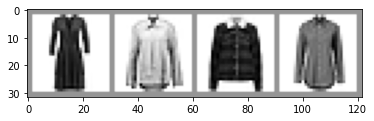

In [30]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    print('size', img.shape)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [29]:
validation_set[0][0].shape

torch.Size([1, 28, 28])

In [11]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

2022-09-29 10:31:13.956755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


In [20]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

In [21]:
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()